# A bow shocks near GRS 1915+105

This notebook is partly based off the calculations presented by Gallo et al. 2004 to interpret the bow shock observed in the vicinity of Cyg X-1. Calculations have been adapted to the case of GRS 1915+105, near which we identified a bow shock similar to (albeit much larger than) that seen close to Cyg X-1. 
Significant additions have been made based on (i) Kaiser et al. 2004, who already modeled a structure near GRS 1915+105 observed in radio, but did not see any large-scale bow shock due to the limited sensitivity of the VLA images they used; and (ii) the python ThunderBooks by R. Fender (https://github.com/robfender/ThunderBooks), which have been used to clarify some of the calculations below. 

A significant difference with respect to Gallo et al. 2004 is that we make the (reasonable) assumption that the hydrogen emitting the bow shock radiation is fully ionized for the densities we are dealing with. This is supported by Saha's equation that predicts that with densities of the order 0.1-1000 particles per unit volume, all hydrogen should be ionized at a temperature of ~10000K. In order to have an ionization fraction different from 1, the density has to be at least 1E+06 particles/cm$^3$, which is way higher than the average ISM density.  

For interpreting the interactions of the large-scale jet structure of GRS 1915+105 with its environment we use the
model developed by Kaiser & Alexander (1997, KA97) for the jets of radio galaxies, and adapted for galactic sources in and Kaiser et al. (2004). We assume that the supersonic jets end in strong shock fronts at the location where they impact on the ambient gas. The gas coming up the jets inflates two lobes that are overpressured with respect to the environment. The lobes therefore expand sideways and thus a bow shock is driven into the surrounding ISM. We identify three regions: 

a) **IRAS 19132+1035** corresponds to the compressed and shock-heated ISM in front of the jet.

b) **a non thermal cylindrical feature** near IRAS 19132+1035 and to its north-east edge, pointing towards GRS 1915+105, which corresponds to the strong shock that originates at the end of the postulated large-scale jet, which in AGN is identified with a hot spot.

c) **A radio lobe**, clearly detected in the MeerKAT image at an average flux density of 0.2 mJy, which corresponds to the edge-brightened radio lobe inflated by the jet material. In the old VLA data, such a bow shock was not detected due to limited sensitivity (interestingly, it was predicted by Kaiser et al. 2004, at approximately the currently observed flux density).

- - - - - 

In order to determine the properties of the jet, we will do as follows.

(1) We **derive the density of the shocked material** in IRAS 19132, assuming that the gas is fully ionised and that the radiation is Bremsstrahlung for a minimum temperature of T ~ 10$^4$K, and modeling the IRAS region as a solid sphere. Then we **infer the pre-shock ISM density** knowing that it should be about a factor of 4 smaller than in the shocked region. 

(2) We model the non-thermal cylindrical feature at the north edge of IRAS and we **derive the minimum energy magnetic field and pressure** assuming synchrotron emission (based on results in the literature that indicate a steep spectrum).

(3) We **estimate the jet advancing velocity** assuming that it equals the velocity of the bow shock in the ISM. From here we can **estimate the jet age**. 

(4) We **estimate the jet energy transport rate** using the density derived above, and the lobe aspect ratio measured from the MeerKAT image. 

(5) Finally, we study the emission properties of the jets, and we **infer the magnetic field and pressure from the radio lobes**, and the **pressure within the non-thermal region** at the north side of IRAS, and compare the values to check the self-consistency of the model.

(6) As a check, we estimate the jet transfer rate also via two simplified methods, based on (i) the estimate of the hentalphy on the jet-ISM system; (ii) a different use of the minimum energy argument previously applied to AGN. 


Note that the treatment below is based on a minimum Bremstrahlung temperature of 1.2e+4 K, which affects the electron density and the jet velocity, as well as the jet power transfer rate. This is done to obtain a strict lower limit to the transferred jet power Q$_{jet}$. At the end of the notebook we will repeat the calculation using a reasonable temperature range in a MC simulation.
 

### Some units:

In [1]:
import matplotlib_inline
import matplotlib.pyplot as plt
import numpy as np
import ipympl

#%matplotlib widget
%matplotlib notebook
# Some Constats and Units

pc = 3.086E+18       # 1 pc, cm 
mh = 1.6735575E-24   # Hydrogen mass, g 
me = 9.1093837E-28   # Electron mass, g 
eV = 1.602176634E-12 # ElectronVolt, erg
Jy = 1.0E-23         # 1 Jansky (erg/s/cm2/Hz), cgs
kb = 1.380649E-16;   # K boltzman, cgs
h =  6.6261E-27;     # Plank constant, cgs 
c = 3.0e10           # Speed of light, cgs 
Na = 6.022E+23       # Avogadro's number
Z=1                  # Hydrogen atomic number
e = 4.8e-10          # Electric charge cm3/2 g1/2 s-1

# Some useful functions

# Gaunt factor 
def gaunt(nu, T, z, gammalor):
    # The Gaunt factor
    F1 = 128.*(1**2)*(kb**3)*(T**3)    
    F2 = me * (e**4)*(nu**2)*(z**2)
    
    G = (3**0.5 / (2.*np.pi)) * (np.log(F1/F2) - gammalor**2)
    
    return G

# Electron density (cylinder unit volume - bow shock)
def ne(d,F,DR,T_axis,nu,Z):
    L14 = F*Jy*4*np.pi*(d*1e3*pc)**2               # Monochormatic ring luminosity in erg/sec/Hz
    Vol = ((np.pi)*(bmaj/2)*(bmin/2))*(DR)*(d*1e3*4.8*1e-6*pc)**3 #Unit volume of the bowshock in cm3 - beam area X DR 
    kappa_nu = L14 / Vol
    C_radio = 6.8*1e-38
    ne_squared = kappa_nu/(C_radio*(T_axis**-0.5) * gaunt(nu, T_axis, Z,gammalor))
    n_e = (ne_squared**0.5) # units: cm^-3
    return n_e

# Electron density (sphere - IRAS)
def nesph(d,Firas,Riras,Temp,nu,Z):
    Rirascm = Riras*0.048*d/10*pc                   # IRAS source size (diameter), cm
    Liras14 = Firas*Jy*(4*np.pi*(d*1000*pc)**2);    # Monochormatic ring luminosity in erg/sec/Hz 
                                                    # (d needs to be divided by 10!)
    fill = 0.5                                      # Volume filling factor
    Volsph = fill*4/3*np.pi*(Rirascm/2)**3;         # Volume = 4/3 pi (D/2)^3, with D = diameter
    C_radio = 6.8*1e-38
    nesph = np.sqrt( (Liras14/Volsph*(np.sqrt(Temp)))/(C_radio*gaunt(nu, Temp, Z, gammalor)*np.exp(h*nu/(kb*Temp ))) )  
    return nesph                                    # Electron density from Bremmsstralung emissivity 

# Electron density (unit volume - IRAS) - NOT using this, not appropriate
def neuv(d,F,DR,T_axis,nu,Z):
    bmaj = 6.6           # Beam major axis, arcsec
    bmin = 6.6           # Beam minor axis, arcsec
    L14 = F*Jy*4*np.pi*(d*1e3*pc)**2 # Average Monochormatic ring luminosity in erg/sec/Hz
    Vol = ((np.pi)*(bmaj/2)*(bmin/2))*(DR)*(0.048*d10*pc)**3; 
    kappa_nu = L14 / Vol
    C_radio = 6.8*1e-38
    ne_squared = kappa_nu/(C_radio*(T_axis**-0.5) * gaunt(nu, T_axis, Z, gammalor))
    n_e_uv = (ne_squared**0.5) # units: cm^-3
    return n_e_uv


In [2]:
# Some Constats and Units

pc = 3.086E+18       # 1 pc, cm 
mh = 1.6735575E-24   # Hydrogen mass, g 
me = 9.1093837E-28   # Electron mass, g 
eV = 1.602176634E-12 # ElectronVolt, erg
Jy = 1.0E-23         # 1 Jansky (erg/s/cm2/Hz), cgs
kb = 1.380649E-16;   # K boltzman, cgs
h =  6.6261E-27;     # Plank constant, cgs 
c = 3.0e10           # Speed of light, cgs 
Na = 6.022E+23       # Avogadro's number
Z=1                  # Hydrogen atomic number
e = 4.8e-10          # Electric charge cm3/2 g1/2 s-1

# Observation-specific quantities

nu = 1.2839E+9;      # Observing frequency, in Hz (L-band, MeerKAT, slightly lower than for Cyg X-1, Westerbork)
bmaj = 6.6           # Beam major axis, arcsec
bmin = 6.6           # Beam minor axis, arcsec

# Source specific quantities

d10 = 0.94;          # distance in units of 10 kpc, GRS 1915+105 --- KNOWN (Reid & Miller-Jones 2023)  
incl = 60;           # Source inclination to line of sight, deg --- KNOWN (Reid et al. 2014)
incl_err = 5         # Error on inclination angle
o_a = 10             # Upper limit to jet opening angle
o_a_err = 0          # Jet opening angle error
Flobe = 0.00015;     # Bow shock/lobe flux density, Jy/beam -- MEASURED
Flobe_err = Flobe/10; 
Firas = 0.057;       # IRAS source INTEGRATED flux density, Jy -- MEASURED 
Firas_err = Firas/10
Firasmean = 0.0033;       # IRAS source MEAN flux density, Jy -- MEASURED 
Firasmean_err = Firas/10

Fcyl = 0.0052;       # Northern feature flux density, Jy -- MEASURED
DR = 60              # Ring thickness, arcsec (on average) -- MEASURED
DR_err = 0.3
DRcm = (DR)*(0.048*d10*pc) # Ring thickness, in cm (on average)
Riras = 36           # IRAS source angular size (diameter), arcsec -- MEASURED 
Riras_err = bmaj/2
Rirascm = Riras*0.048*d10*pc # IRAS source size (diameter), cm

theam = 10;                                   # Lobe angular size (diameter ortogonal to jet direction) in arcmin (projected) GRS 1915 --- MEASURED
lobesizepc = (theam*60)*0.048*d10             # Lobe diameter in pc GRS 1915+105 --- MEASURED
lobesizecm = lobesizepc*pc                    # Lobe diameter (does NOT need to be de-projected 'cause this is measured as ortoigonal to the jet direction) in cm GRS 1915+105

disamin = 17;                                 # Lobe-source angular distance in arcmin (projected) GRS 1915+105 --- MEASURED
disamin_err = 0.2
dispcP = (disamin*60)*0.048*d10;              # source-ring separation (projected), in pc (= Lj, pc)
discmP = dispcP*pc;                           # source-ring separation, (projected) in cm
dispc = (disamin*60)*0.048*d10/np.sin(incl*np.pi/180);  # source-ring separation (DE-PROJECTED), in pc (= Lj, pc)
discm = dispc*pc;                             # source-ring separation, DE-PROJECTED in cm (= Lj, cm)

gammalor = 1.02                                # Lorentz factor of the jet


print('Lobe diameter [pc] (lobesizepc) =', '{:.3e}'.format(lobesizepc)) #Lj
print('Lobe diameter [cm] (lobesizecm) =', '{:.3e}'.format(lobesizecm)) #Lj
print('Source-ring separation (projected) [pc] (dispcP) ~','{:.3e}'.format(dispcP))
print('Source-ring separation (projected) [cm] (discmP) ~','{:.3e}'.format(discmP))
print('Source-ring separation (de-projected) [pc] (dispc) ~','{:.3e}'.format(dispc))
print('Source-ring separation (de-projected) [cm] (discm = Lj)~','{:.3e}'.format(discm))

# Assumptions
x = 1;               # Ionization fraction at T ~ 10^4
n_iter = 5000


Tmax = np.max(3*(10**6));
Tmin = np.min(1e+4);                         # Lower-limit to post-shock temperature -- ASSUMED 
                                             # (from arguments based on Bremsstrahlung nature of the emission)
                                             # Also see Saha's equation below

T_axis = np.linspace(Tmin,Tmax, n_iter, endpoint=True)

g = gaunt(nu, Tmin, Z,gammalor)


print('Tmin ~' ,Tmin)
print('Tmax ~' ,Tmax)
print('Gaunt_min ~' ,g)

#print('Rirascm', Rirascm)
#Liras14 = Firas*Jy*(4*np.pi*(d10*10*1000*pc)**2);
#print('Liras', Liras14)

Lobe diameter [pc] (lobesizepc) = 2.707e+01
Lobe diameter [cm] (lobesizecm) = 8.354e+19
Source-ring separation (projected) [pc] (dispcP) ~ 4.602e+01
Source-ring separation (projected) [cm] (discmP) ~ 1.420e+20
Source-ring separation (de-projected) [pc] (dispc) ~ 5.314e+01
Source-ring separation (de-projected) [cm] (discm = Lj)~ 1.640e+20
Tmin ~ 10000.0
Tmax ~ 3000000
Gaunt_min ~ 7.727400776257689


## Large scale structure of the jet

### 1)  IRAS 19132 - Bremsstrahlung

The emission from IRAS 19132 is characterised by a flat radio spectrum, which suggests a bremsstrahlung origin from a gas emitting at a temperature of T $\sim 10^4K$. This is supported by the detection of a H92$\alpha$ recombination line with width 25 km/s (Rodriguez & Mirabel 1998), which suggests a temperature of at least T $\sim$1.2$\times$ 10$^4K$.



The **monochromatic emissitivty $\epsilon_\nu$ of ionised hydrogen due to thermal bremsstrahlung** is given by (Longair 1994). 

 $$\epsilon_\nu = \frac{L_\nu}{V} = C_{radio} g(\nu, T) \frac{n_e^2}{\sqrt{T}} \exp{(\frac{h\nu}{k_b T})} ~~ erg~s^{-1}~cm^{-3}~Hz^{-1}$$

where 

$$ C_{radio} = 6.8\times 10^{-38} erg~s^{-1}~cm^{-3}~Hz^{-1} $$

Note that in Kaiser+2004 the constant is ~$10^{50}$ because the number densities are expressed in particles per meter cube: $(m^3)^2 = 10^{12} (cm^3)^2$.

The above assumes that **the number of electrons $n_e$ equals the number of protons $n$** (pure hydrogen gas), and that the density and temperature are uniform within the volume considered. $\epsilon_\nu$ is the expression of the Bremsstrahlung emissivity for a pure hydrogen gas emitting at a temperature T, and $V$ is the source unit volume. Since we have no information regarding the extent of the emission regions along our line of sight or their exact three-dimensional geometrical structure, **we assume a spherical shape with diameter 36 arcsec, multiplied by a filling factor f$\sim$0.5** to take into account the fact that the region is probably multi-phase (hot gas and cold gas may co-exist), and only the hot gas is responsible for the Bremsstrahlung emission. 

From the Bremsstrahlung emissivity we can derive the electron density. 

$$n_e = \sqrt\frac{\epsilon_\nu}{g(\nu, T) \sqrt{T} C_{radio} \exp{(\frac{h\nu}{k_b T})}}$$

where the Gaunt factor g($\nu$) is given by 

$$g(\nu, T) \approx \frac{\sqrt{3}}{2 \pi}\left[\ln \left(\frac{128 \epsilon_0^2 k^3 T^3}{m_e e^4 \nu^2 Z^2}\right)-\gamma^2\right]$$

As stated above, since we assume that the hydrogen in the region is fully ionized, the electron number density also corresponds to the total particle number density (under the assumption that the ISM is almost all hydrogen). 
**The electron density _in the shock_ is about 140 particles per cm$^3$**, and thus, assuming that the shock is approximately 4 times denser than the surrounding medium, **the unshocked ISM electron density is about 35 particles per cm$^3$**. This is consistent with the typical density of an HII region, a factor ~10 or larger than the typical ISM density (1/cm$^3$). Since the bow shock seems to be connected with an HII region (CHIMPS 4894, based on SIMBAD, see http://simbad.cds.unistra.fr/simbad/sim-id?Ident=CHIMPS+4894&), the density we find seems appropriate. 

In [3]:
neuvmin = neuv(d10*10,Flobe,DR,Tmin,nu,Z)
neuvmax = neuv(d10*10,Flobe,DR,Tmax,nu,Z)
ntuvmin = neuvmin/x;                                    # Total particle density, which equals the electron 
ntuvmax = neuvmax/x;                                    # Total particle density, which equals the electron 
print('>> Particle number density of shocked gas in the lobe [1/cm3] (ntmin = ne/x) =','{:.3e}'.format(ntuvmin))
print('>> Particle number density of shocked gas in the lobe [1/cm3] (ntmax = ne/x) =','{:.3e}'.format(ntuvmax))

neuvminiras = neuv(d10*10,Firasmean,DR,Tmin,nu,Z)
neuvmaxiras = neuv(d10*10,Firasmean,DR,Tmax,nu,Z)
ntuvminiras = neuvminiras/x;                                    # Total particle density, which equals the electron 
ntuvmaxiras = neuvmaxiras/x;                                    # Total particle density, which equals the electron 
print('>> Min Particle number density of shocked gas in IRAS (using unit volume) [1/cm3] (ntmin = ne/x) =','{:.3e}'.format(ntuvminiras))
print('>> Max Particle number density of shocked gas in IRAS (using unit volume) [1/cm3] (ntmax = ne/x) =','{:.3e}'.format(ntuvmaxiras))
print('!!! IRAS estimates probably underestimated because the volume is smaller (not cylinders)')

>> Particle number density of shocked gas in the lobe [1/cm3] (ntmin = ne/x) = 2.334e+01
>> Particle number density of shocked gas in the lobe [1/cm3] (ntmax = ne/x) = 7.754e+01
>> Min Particle number density of shocked gas in IRAS (using unit volume) [1/cm3] (ntmin = ne/x) = 1.095e+02
>> Max Particle number density of shocked gas in IRAS (using unit volume) [1/cm3] (ntmax = ne/x) = 3.637e+02
!!! IRAS estimates probably underestimated because the volume is smaller (not cylinders)


In [4]:
# Section 1: Calculating the gas density downstream with respect to the shock front, assuming 
# bremsstralung emission

fill = 1
Volsph = fill*4/3*np.pi*(Rirascm/2)**3;             # Volume = 4/3 pi (D/2)^3, with D = diameter
Liras14 = Firas*Jy*(4*np.pi*(d10*10*1000*pc)**2);   # Monochormatic luminosity in erg/sec/Hz 
                                                    # for a pure hydrogen gas emitting at Temp
nemin = nesph(d10*10,Firas,Riras,Tmin,nu,Z)
nemax = nesph(d10*10,Firas,Riras,Tmax,nu,Z)
ntmin = nemin/x;                                    # Total particle density, which equals the electron 
ntmax = nemax/x;                                    # Total particle density, which equals the electron 
                                            ## density divided by ionization fraction, which in 
                                                    ## this case is 1 (for fully ionized hydrogen)
rhomin = ntmin*1.370*mh                             ## Density of the gas post-shock, i.e. down-stream of 
                                                    ## the shock, g/cm3
rho0min = rhomin/4;                                 ## Density of the pre-shock gas, i.e. up-stream of the 
                                                    ## shock, g/cm3
   
ringuv = ((np.pi)*(bmaj/2)*(bmin/2))*(DR)*(0.048*d10*pc)**3; 
Llobe = Flobe*Jy*(4*np.pi*(d10*10*1000*pc)**2);    # Monochormatic luminosity in erg/sec/Hz 


#print('Ring thickness [cm] (DRcm) =','{:.3e}'.format(DRcm))
print('Ring unit volume [cm^3] (ringuv) =','{:.3e}'.format(ringuv))
print('Ring average monochromatic Luminosity [erg/s/Hz] (Liras14) =', '{:.3e}'.format(Llobe))

print('IRAS volume [cm^3] (Volsph) =', '{:.3e}'.format(Volsph))
print('IRAS INTEGRATED monochromatic Luminosity [erg/s/Hz] (Liras14) =', '{:.3e}'.format(Liras14))
print('>> Particle number density of shocked gas [1/cm3] (ntmin = ne/x) =','{:.3e}'.format(ntmin))
print('>> Particle number density of shocked gas [1/cm3] (ntmax = ne/x) =','{:.3e}'.format(ntmax))
print('>> Particle number density of un-shocked gas [1/cm3] (nt0min = ntmin/4) =','{:.3e}'.format(ntmin/4))
print('Density of shocked gas [g/cm3] (rhomin) =','{:.3e}'.format(rhomin))
print('Density of un-shocked gas [g/cm3] rho0min =','{:.3e}'.format(rho0min))

print(Llobe/ringuv)
print(Liras14/Volsph)

R = Na*kb # gas constant
# Cross check the pressure of gas in ideal conditions. 
# pressure of gas inside IRAS source assuming ideal conditions
pidealmin = ntmin*kb*Tmin
pidealmax = ntmin*kb*Tmax

print('>> Pressure inside IRAS (ideal gas conditions) [erg/cm3] (Pideal) = ', '{:.3e}'.format(pidealmin))

# pressure of gas of unshocked material assuming ideal conditions, and T = 50K
pidealunsh = ntmin*kb*50
print('>> Pressure in the ISM (ideal gas conditions) [erg/cm3] (pidealunsh) =', '{:.3e}'.format(pidealunsh))

Ring unit volume [cm^3] (ringuv) = 5.541e+54
Ring average monochromatic Luminosity [erg/s/Hz] (Liras14) = 1.586e+19
IRAS volume [cm^3] (Volsph) = 6.595e+55
IRAS INTEGRATED monochromatic Luminosity [erg/s/Hz] (Liras14) = 6.027e+21
>> Particle number density of shocked gas [1/cm3] (ntmin = ne/x) = 1.865e+02
>> Particle number density of shocked gas [1/cm3] (ntmax = ne/x) = 6.196e+02
>> Particle number density of un-shocked gas [1/cm3] (nt0min = ntmin/4) = 4.663e+01
Density of shocked gas [g/cm3] (rhomin) = 4.276e-22
Density of un-shocked gas [g/cm3] rho0min = 1.069e-22
2.8623624950617084e-36
9.139682466870654e-35
>> Pressure inside IRAS (ideal gas conditions) [erg/cm3] (Pideal) =  2.575e-10
>> Pressure in the ISM (ideal gas conditions) [erg/cm3] (pidealunsh) = 1.288e-12


### 2) Northern feature in IRAS 19132 - Synchrotron emission from gas (hot spot)

The radio maps of IRAS 19132+1035 show an elongated feature pointing in the direction of GRS 1915+105, with lengths of 17.4 arcsec, and width of 7.9 arcsec, and with a steep radio spectrum, located to the northwest of the main flat spectrum region. In the old VLA images this spectrum is consistent with a power law F $\propto$ $\nu^\alpha$ with $\alpha$ = -0.8.  This spectral index is typical for synchrotron emission and hence it implies the presence of a relativistic plasma consisting of magnetic field and a population of relativistic electrons. 

We will assume that we observe(or infer) a radio spectrum with some spectral index $\alpha$ between upper and lower frequencies $\nu_1, \nu_2$. We will need the integrated radio luminosity between these limits, and not just the specific radio luminosity at a certain frequency.

$$L=4 \pi D^2 \int_{\nu_1}^{\nu_2} F_{\nu} d\nu = 4 \pi D^2 F_{\nu_2} \nu_2^{-\alpha} \left( \frac{\nu_2^{\alpha+1} - \nu_1^{\alpha+1}}{\alpha+1} \right) $$

(an equivalent formula can of course be constructed using $\nu_1$ as the reference frequency). 
Here we use $\alpha = (1-p)/2$.**

Note, in comparing the analysis here with the simplified (but relatively accurate) formula of Longair et al. 1994, that the $L_{\nu}$ used in that formula is the 'specific' luminosity in units erg s$^{-1}$ Hz$^{-1}$ whereas the *integrated* luminosity used here and defined above is in erg s$^{-1}$, and is therefore a larger quantity).

The energy density in magnetic fields is $B^2 / 8\pi$ (in cgs units), therefore for a volume $V$ the total energy in B fields is:

$$E_B = \frac{B^2}{8 \pi} f V $$

where $f$ is a *filling factor* which represents the fraction of the physical source's volume which is actually occupied by the magnetic field and relativistic particles.

Given a population of electrons with a power law distribution $-p$ between energy limits $E_1$ and $E_2$, the total energy in these electrons is given by:

$$E_e = c_2^{-1} L B^{-2} \frac{(p-3)}{(p-2)} \frac{(E_1^{2-p}-E_2^{2-p})}{(E_1^{3-p}-E_2^{3-p})}$$

For a given electron energy and magnetic field, we can characterise the synchrotron emission as coming from a single frequency $\nu = c_1 B E^2$, i.e. $E = \nu^{1/2} c_1^{-1/2} B^{-1/2}$. So, we can write:

$$E_e = c_2^{-1} c_1^{1/2} \tilde{c}(p, \nu_1, \nu_2) B^{-3/2} L = c_{12}(p,\nu_1,\nu_2) B^{-3/2} L$$

where

$$c_{12} = c_2^{-1} c_1^{1/2} \tilde{c}(p, \nu_1, \nu_2)$$

and

$$\tilde{c}(p, \nu_1, \nu_2) = \frac{(p-3)}{(p-2)} \frac{\nu_1^{(2-p)/2}-\nu_2^{(2-p)/2}}{\nu_1^{(3-p)/2}-\nu_2^{(3-p)/2}}$$

The pseudo-constant $c_{12}$ encapsulates all the information about the observed (or interpolated, extrapolated, assumed) frequency range of the observations and the slope of the energy spectrum between those limits. 

Since $E_B \propto B^2$, the total energy is given by

$$E_{e+B} = E_e + E_B =  const. B^{-3/2} + const. B^2$$

and therefore *there must be a minimum of the total energy as a function of $B$* (assuming there are no other contributions to the energy budget which have a different dependence on $B$). This minimum occurs at *equipartition* of the energy, when $E_e$ and $E_B$ are almost equal (which can be calculate by differenting $E_{e+B}$ with respect to $B$):

$$E_B = \frac34 \eta E_e$$

where $\eta$ indicates how much energy is stored in the protons which accompany the electrons (in the case of a normal baryonic plasma); $\eta = 1$ is generally considered for the minimum energy condition.
Substituting the above expressions, the equipartition magnetic field is given by:

$$B_{eq} = (6 \pi \frac{\eta}{f} c_{12} \frac{L}{V})^{2/7} $$



For minimum energy conditions the total pressure in this feature is then given by:

$$ p = \frac{7}{9} \frac{B^2_{min}}{8\pi}(k+1)$$

with k equal the ratio of the internal energy stored in any particles that do not contribute to the synchrotron emission to the sum of the energy in the magnetic field and in the relativistic electrons.
Here we assume a cylindrical geometry for the northern feature, with a radius equivalent to 3.9 arcsec and a length of 17.4 $\times$ sin$\theta^{-1}$ arcsec, where $\theta$ is the angle of the long axis of the cylinder to our line of sight.

The volume of the feature is **Vcyl ~ 2e+54 cm$^3$**, and its total luminosity is **Lcyl ~ 1.7e+29 erg/s**. The predicted minimum energy **magnetic field is Bmin ~ 2.2e-05 G**, and the minimum energy **pressure is 1.6e-11 erg/cm$^3$**. 

In [5]:
# This is adapted from the ThunderBook "Equipartition analysis" (https://github.com/robfender/ThunderBooks)
D = d10*10
k = 0.01          
nu1=1.0e7
nu2=1.0e11
p=2.5
alpha=(1.0-p)/2.0
eta = 1
f = 1

# Pseudoconstant
c1=6.27e18
c2=2.37e-3
# speed of light 
c=3.0e10
# relativistic sound speed of c/sqrt[3]
cs=c/(3.0**0.5)

ctildetop=(nu1**((2.0-p)/2.0))-(nu2**((2.0-p)/2.0))
ctildebottom=(nu1**((3.0-p)/2.0))-(nu2**((3.0-p)/2.0))
ctilde=((p-3.0)/(p-2.0))*(ctildetop/ctildebottom)
c12=(c2**-1.0)*(c1**0.5)*ctilde

def LumTot(snu2,D,nu1,nu2,alpha): 
# here s is the flux density at the upper frequency nu2
    L2 = 4 * np.pi * ((D * 3.1e21)**2.0) * (snu2 * 1e-26) * (nu2**(-alpha)) * ((nu2**(1+alpha))-(nu1**(1+alpha))) / (1+alpha)
    #print (('Calculated total radiative luminosity'),('L ='),('%.2e' % L2),(' erg / sec '))
    return L2

Lcy = LumTot(Fcyl,(d10*10),nu1,nu2,alpha)    #  Note that this is the INTEGRATED luminosity, not the monochromatic one


rcyl = 3.9
lencyl = 17.4

rcylcm = rcyl*(0.048*d10*pc)                         # Radius of cylindric feature, cm
lencylcm = lencyl*(0.048*d10*pc)/np.sin(incl*np.pi/180)  # Lenght of cylindric feature, cm
VolCyl = np.pi*rcylcm**2*lencylcm                   # Volume of cylindric feature, cm3

Bmin = (6*np.pi*(eta/f)*c12*Lcy/VolCyl)**(2/7)  # Equipartition magnetic field, Gauss
# Total pressure in this feature for minimum energy conditions

pmincyl = 7/9*Bmin**(2)/(8*np.pi)*(k+1)       # Equipartition pressure, erg/cm3


print('Cylinder Integrated Luminosity [erg/s] (Lcy) =','{:.3e}'.format(Lcy))
print('Cylinder Volume [cm3] (VolCyl) =','{:.3e}'.format(VolCyl))
print('>> Cylinder magnetic field density [G] (Bmin) = ','{:.3e}'.format(Bmin))
print('>> Cylinder pressure [erg/cm3] (pmincyl) ~','{:.3e}'.format(pmincyl))

# From Kaiser+2004, for a reality check

#LcylK = 6e+18*D**2
#VolK = 9.9E-05*(D)**3/math.sin(incl*np.pi/180)*pc**3
#BminK = 1.0E-6*120*(math.sin(incl*np.pi/180)/(D))**(2/7)
#pminK = 1.0E-10*(4.3*(math.sin(incl*np.pi/180)/(D))**(4/7))*(k+1)

#print('LcylK ~',LcylK)
#print('VolK ~',VolK)
#print('BminK ~',BminK)
#print('pminK ~',pminK)

#print(lencyl*2./pc)
#print(lencyl/pc)
#print(alpha)

Cylinder Integrated Luminosity [erg/s] (Lcy) = 1.998e+29
Cylinder Volume [cm3] (VolCyl) = 2.592e+54
>> Cylinder magnetic field density [G] (Bmin) =  2.182e-05
>> Cylinder pressure [erg/cm3] (pmincyl) ~ 1.488e-11


## The jet model

For interpreting the interactions of the large-scale jet structure of GRS 1915+105 with its environment we use the
model developed in Kaiser & Alexander (1997, KA97) for the jets of radio galaxies, and adapted for galactic sources in and Kaiser et al. (2004). The supersonic jets end in strong shock fronts at the location where they impact on the ambient gas. The gas coming up the jets inflate two lobes that are overpressured with respect to the environment. The lobes therefore expand sideways and thus a bow shock is driven into the surrounding ISM. We identify three regions: 

a) **IRAS 19132** corresponds to the compressed and shock-heated ISM in front of the jet.

b) **the norther cylindrical feature** near IRAS 19132+1035, pointing towards GRS 1915+105, corresponds to the strong shock that originates at the end of the postulated large-scale jet.

c) **the radio lobe clearly seen in the MeerKAT image at an average flux density of 0.2 mJy** corresponds to the edge-brightened radio lobe inflated by the jet material. In the old VLA data such a bow shock was not detected due to limited sensitivity (but it was predicted by Kaiser et al. 2004, at approximately the currently observed flux density).


### 1) Applicability (characteristic jet lenght)

The model assumes a constant energy transport rate, Q0, for each side of the jet. This transport rate is averaged over the lifetime of the jets. We assume that the ambient medium has a constant density. Under these circumstances the evolution of the large-scale structure created by the jet (lobe and bow shock), is self-similar once the jet extends beyond its characteristic length scale, given by (KA97): 

$$ L_0 = (\frac{\rho_0^2 Q_0}{\dot{M}_0^3})^{-1/4} = [\frac{Q_0^2}{\rho_0^2 c^6(\gamma_j -1)}]^{1/4}$$

where $\dot{M_0}$ is the mass transport rate of the jet, and $\gamma_j$ is the Lorentz factor of the jet material.

The density of the gas that has been shock-heated by the impact of the jets, which we calculated based on the Bremsstrahlung luminosity of IRAS 19132, is approximately 4 times that of the pre-shock value $\rho_0$. 

Estimating the Lorentz factor of jet flows is notoriously difficult (e.g., Fender 2003). Furthermore, the observed motion of radio ‘‘knots’’ in the jets may simply reflect the motion of shocks along the jets rather
than the bulk motion of the jet material. Any estimate of $\gamma_j$ will also depend on the distance to the source and the orientation of the jet to our line of sight. Here we use the conservative lower limit  $\gamma_j$ = 1.1, which maximizes L$_0$.

For reasonable values of Q$_0$ (~ 10$^{36}$ erg/s, see below), L$_0$ is of the order  10$^{-05}$ pc, i.e.,  orders of magnitude smaller than the jet lenght L$_j$ (> 40 pc), and therefore the model by KA97 is valid for GRS 1915+105. 

In [6]:
# Calculation of L0

gammaj = 1.1
Q0 = 1.0E+36

L0 = ( (Q0**2) / (rho0min**2*c**6*(gammaj-1)) )**(1/4)

print('Characteristic jet length scale [pc] (L0) = ', '{:.3e}'.format(L0/pc))
print('Jet length [pc] (Lj) = ', '{:.3e}'.format(discm/pc))


Characteristic jet length scale [pc] (L0) =  1.073e-05
Jet length [pc] (Lj) =  5.314e+01


### 2) Shock front velocity and age of the jet

KA97 showed that the velocity of the bow shock is roughly equal to the advance speed of the end of the jet driving this shock, which is given by:

$$ \dot{L} = \sqrt{\frac{16 k_b}{3 m_p}T}$$

where $m_p$ is the mass of the proton. 
For a strong shock in a mono-atomic gas, the expansion velocity is set by the temperature of the shocked gas. If the shock is radiative, then the initial post-shock temperature can be higher than that of the thermalized, bremsstrahlung-emitting gas. A stringent constraint on the temperature could come from X-ray observations, which we will have soon via Chandra. 

We estimate a minimum **shock velocity of 23 Km/s**, which implies that the bow shock will be highly supersonic with respect to the unshocked ISM. Note that the kinematic of the gas in the region is complex,  and hence T$_{min}$ could be overestimated.

In [7]:
vdmin = ( (16*Tmin*kb)/(3*mh) )**(1/2)/1.0E+5;# Lower-limit to Ljdot, i.e., post-shock velocity, in Km/s

vdmaxcm = ( (16*Tmin*kb)/(3*mh) )**(1/2);     # Lower-limit to Ljdot, i.e., post-shock velocity, in cm/s
vdmaxcm = ( (16*Tmax*kb)/(3*mh) )**(1/2);     # Upper-limit to Ljdot, i.e., post-shock velocity, in cm/s

vdmincm = vdmin*1.0E+5;  #Ldot                # Lower limit to ring velocity, in cm/s 

print('>> Shock front velocity [Km/s] (vd1 = Ldotmin) ~','{:.3e}'.format(vdmin))
print('>> Min Shock front velocity [cm/s] (vd1 = Ldotmin) ~','{:.3e}'.format(vdmincm))
print('>> Max Shock front velocity [cm/s] (vd1 = Ldotmin) ~','{:.3e}'.format(vdmaxcm))

#TminP = 20
#print(( (16*TminP*kb)/(3*mh) )**(1/2)/1.0E+5)


>> Shock front velocity [Km/s] (vd1 = Ldotmin) ~ 2.098e+01
>> Min Shock front velocity [cm/s] (vd1 = Ldotmin) ~ 2.098e+06
>> Max Shock front velocity [cm/s] (vd1 = Ldotmin) ~ 3.633e+07


For a constant density medium Kaiser+2004 showed that the jet length within the lobe grows with the time $t$ in such a way that

$$ L_j = C_1 ~(\frac{Q_0}{\rho_0})^{1/5}~ t^{3/5}$$ 

Taking the time derivartive of this equation we obtain:

$$ \dot{L_j} = \frac{3 Lj}{5 t}$$

, which implies:

$$ t = \frac{3 L_j}{5 \dot{L_j}} $$

This expression can be used to estimate the upper limit to the age of the jet, which is approximately 1 Myr.
C1 is a dimensionless constant that depends on the thermodynamical properties of the jet material, and on the aspect ratio, R, of the lobe inflated by the jet (R is the length of the lobe divided by its width). The esplicit form of C1 is the following:

$$ C_1=\left(\frac{C_2}{C_3\theta^2}\frac{(\Gamma_x+1)(\Gamma_c-1)(5-\beta)^3}{18\left[9\{\Gamma_c+(\Gamma_c-1)\frac{C_2}{4\theta^2}\}-4-\beta\right]}\right)^{\frac{1}{(5-\beta)}}$$

with

$$C_2=\left(\frac{(\Gamma_c-1)(\Gamma_j-1)}{4\Gamma_c}+1\right)^{\frac{\Gamma_c}{(\Gamma_c-1)}}\frac{(\Gamma_j+1)}{(\Gamma_j-1)}$$

and 

$$C_3=\frac{\pi}{4R_{\rm ax}^2}$$


(Tetarenko et al. 2018, Appendix C), and the value of the constant is calculated below.

In [8]:
# The constant C1 is given in the following (see Appendix C in Tetarenko et al. 2018): 

# The constant C1 can ba calculated making assumptions on the jet properties and on the environment, 
# which we will treat as uniform in density. We also make assumptions on the adiabatic index of the 
# material in the cavity, in the external medium, and in the jet. 
# Keeping the adiabatic indices = 5/3, in order to recover a constant of about 2, we need to assume 
# jet opening angle of 30 degrees, which might be a bit high. 

Gammac = 5/3                            # Adiabatic index of the material in the cavity, -- ASSUMED 
Gammax = 5/3                            # Adiabatic index of the material in the external medium, -- ASSUMED 
Gammaj = 5/3                            # Adiabatic index of the material in the jet, -- ASSUMED 

def C_cons(g_c,g_j,g_x,ope):
    beta = 0                                # density profile index (beta = 0 for a uniform density medium), -- ASSUMED 
    theta_ra = ope*np.pi/180                # Jet opening angle, in radiants
    C2_0 = (((g_c-1)*(g_j-1))/(4*g_c) + 1 )**(g_c/(g_c-1)) * ((g_j+1)/(g_j-1))
    Rax_0 = np.sqrt((1/4*(C2_0/theta_ra**2))) # axial ratio of the jet-blown cavity                         
    C3_0 = np.pi/(4*Rax_0**2)
    C1_0 = ((C2_0)/(C3_0*theta_ra**2)*((g_x+1)*(g_c-1)*(5-beta)**3)/(18*(9*(g_c + (g_c -1)*(C2_0/(4*theta_ra**2))) - 4 - beta)) )**(1/(5-beta))
    return C1_0

Con1 = C_cons(Gammac, Gammaj,Gammax, 30)

print('Con1 ~', Con1)

#print(dispc)
#print(lobesizepc)

Con1 ~ 1.9932080579528801


In [9]:
# Section 3: the jet age

def age(disamin,d,incl,v):
    disasec = disamin*60 #lobe target seperation in arcsec (projected)
    dispc = disasec*d*1e3*4.8*1e-6  #lobe target separation in pc (projected)
    discmP = dispc*pc #lobe target sepeartion in cm (projected)
    discm = discmP/np.sin(incl*np.pi/180) #lobe target de-projected seperation to account for the inclination angle
    t = 3/5*(discm/v) #time in seconds
    t_age_Myr = t/(365.*24.*60*60)/1.0E+6 #age of shock in Myr
    return t_age_Myr
    
tmaxMyr = age(disamin,(d10*10),incl,vdmincm)
tminMyr = age(disamin,(d10*10),incl,vdmaxcm)

tsmax = tmaxMyr*(365.*24.*60*60)*1.0E+6          # Upper limit to lobe age in s
tsmin = tminMyr*(365.*24.*60*60)*1.0E+6          # Upper limit to lobe age in s

#print(disamin,(d10*10),incl,vdmincm)
print('Jet age [Myr] (tmaxMyr) =', '{:.3e}'.format(tmaxMyr))
print('Jet age [Myr] (tmaxMyr) =', '{:.3e}'.format(tminMyr))

Jet age [Myr] (tmaxMyr) = 1.488e+00
Jet age [Myr] (tmaxMyr) = 8.588e-02


We note that based on the results of the sub-mm observations reported by Tetarenko et al. 2018 
(https://ui.adsabs.harvard.edu/abs/2018MNRAS.475..448T/) the shock velocity estimated from the SiO detection would be ~ 1Km/s, which implies a jet of approximately 25 Myr, i.e. significantly older than what we predict.

### 3) Energetics

Assuming that the jet direction remains constant over time,  and that the jet is colliding with a medium of densit $\rho_0$, the power Q$_{jet}$ being transported by the jets averaged over its lifetime, **is solely dependent on the properties of the ISM** at the interaction site. Combining the equations for $L_j$ and $\dot{L_j}$ given above we obtain: 

$$ Q_{jet} = (\frac{5}{3})^3~\frac{\rho_0}{C_1^5}L_j^2 ~\dot{L_j}^3$$

The constant C$_1$ can be calculated and it depends on the aspect ratio R of the lobe inflated by the jet, the lobe lenght divided by its width. For extragalactic jet sources, R ~ 2. In the case of the lobe in GRS 1915+105, R is appriximately R ~ 11.16/sin(theta)/8 = 1.5, hence we will assume C$_1$ = 1.5. Below we calculate the constant explicitly (note that a value of 1.5 implies a jet opening angle of 50 degrees).
We obtain that the **minimum energy transferred to the environment is Q$_{jet}$ ~ 1.4e+37 erg/s**. 

The pressure inside the lobe is given by: 

$$ p = 0.0675 \frac{C_1^{10/3}}{R^2}(\frac{\rho_0 Q_0^2}{L_j^4})^{1/3}$$

Which is $p_{lobe}$ ~ 3.6e-11 erg/cm$3$, i.e. significantly overpressured with respect to the unshocked ISM (for a temperature of 50K, a typical ISM pressure would be of the order 10$^{-12}$ erg/cm$3$ assuming that ideal gas conditions, see Section 1), but similar to the pressure we obtain for the cylindrical feature stemming from IRAS 19132+1035.

In [10]:
# Section 4: the jet energy transport rate

# Con1arb = 2
# Rarb = 2

# Min and max depend on the temperature, which gives both the jet velocity and material density. 

# Qjetminarb = (5/3)**3 * rho0min/(Con1arb**5)*(discm**2)*(vdmincm**3)   # Lower limit to time averaged jet power 

# pminjetarb = 0.0675*(Con1arb**(10/3)/Rarb**2)*(rho0min*Qjetmin**2/(discm**4))**(1/3)
# print(Con1arb,Rarb,rho0min,Qjetmin,discm)

# print(Qjetminarb,pminjetarb)


def power(theta,d,nee,disamin,vcm):
    beta = 0
                                           # Theta is the jet opening angle in degrees
                                           # d is the distance in kpc
                                           # nee is the number of electrons
                                           # disamin lobe target seperation in arcsec (projected)
                                           # vcm velocity
    theta_rad = theta*np.pi/180            # Jet opening angle, in radiants
    Con2 = (((Gammac-1)*(Gammaj-1))/(4*Gammac) + 1 )**(Gammac/(Gammac-1)) * ((Gammaj+1)/(Gammaj-1))
    Rax = np.sqrt((1/4*(Con2/theta_rad**2))) # axial ratio of the jet-blown cavity                         
    Con3 = np.pi/(4*Rax**2)
    Con1 = ((Con2)/(Con3*theta_rad**2)*((Gammax+1)*(Gammac-1)*(5-beta)**3)/(18*(9*(Gammac + (Gammac -1)*(Con2/(4*theta_rad**2))) - 4 - beta)) )**(1/(5-beta))
    #nt=ne/x #where x is the ionisation fraction and is 1, use ne and nt interchangeably in the next equation  
    rho = nee*1.370*mh;                    # Density of the gas up-stream of the shock, in cm-3 (calculated above with the calorimetry method above)
    rho0 = rho/4;                          # Density of the gas, down-stream of the shock, in cm-3
    disasec = disamin*60                   # lobe target seperation in arcsec (projected)
    dispc = disasec*d*1e3*4.8*1e-6         # lobe target separation in pc (projected)
    discmP = dispc*pc                      # lobe target sepeartion in cm (projected)
    discm = discmP/np.sin(incl*np.pi/180)  # lobe target de-projected seperation to account for the inclination angle
    Pjet = (5/3)**3 * rho0/(Con1**5)*(discm**2)*vcm**3   # Upper limit to time averaged jet power 
    return Pjet

Qjetmin  = power(o_a,d10*10,nemin,disamin,vdmincm)

#print(Rax,Con1)

def press(theta,d,nee,disamin,vcm):
    beta = 0
                                           # Theta is the jet opening angle in degrees
                                           # d is the distance in kpc
                                           # nee is the number of electrons
                                           # disamin lobe target seperation in arcsec (projected)
                                           # vcm velocity
    theta_rad = theta*np.pi/180            # Jet opening angle, in radiants
    Con2 = (((Gammac-1)*(Gammaj-1))/(4*Gammac) + 1 )**(Gammac/(Gammac-1)) * ((Gammaj+1)/(Gammaj-1))
    Rax = np.sqrt((1/4*(Con2/theta_rad**2))) # axial ratio of the jet-blown cavity                         
    Con3 = np.pi/(4*Rax**2)
    Con1 = ((Con2)/(Con3*theta_rad**2)*((Gammax+1)*(Gammac-1)*(5-beta)**3)/(18*(9*(Gammac + (Gammac -1)*(Con2/(4*theta_rad**2))) - 4 - beta)) )**(1/(5-beta))
    #nt=ne/x #where x is the ionisation fraction and is 1, use ne and nt interchangeably in the next equation  
    rho = nee*1.370*mh;                    # Density of the gas down-stream of the shock, in cm-3 (calculated above with the calorimetry method above)
    rho0 = rho/4;                          # Density of the gas, up-stream of the shock, in cm-3
    disasec = disamin*60                   # lobe target seperation in arcsec (projected)
    dispc = disasec*d*1e3*4.8*1e-6         # lobe target separation in pc (projected)
    discmP = dispc*pc                      # lobe target sepeartion in cm (projected)
    discm = discmP/np.sin(incl*np.pi/180)  # lobe target de-projected seperation to account for the inclination angle
    Pjet = (5/3)**3 * rho0/(Con1**5)*(discm**2)*vcm**3   # Upper limit to time averaged jet power 
    pminjet = 0.0675*(Con1**(10/3)/Rax**2)*(rho0*Pjet**2/(discm**4))**(1/3)
    return pminjet

pminjet = press(o_a,d10*10,nemin,disamin,vdmincm)

print('>> Minimum transferred jet power [erg/s] (Qjetmin) ~ ','{:.3e}'.format(Qjetmin))
print('>> Jet pressure [erg/cm3] (pminlobes) ~ ','{:.3e}'.format(pminjet))


>> Minimum transferred jet power [erg/s] (Qjetmin) ~  3.183e+35
>> Jet pressure [erg/cm3] (pminlobes) ~  2.286e-12


In [12]:
# Based on electron density from Tetarenko et al. 2018
vdminT = 1 #; Km/s
vdmincmT = vdminT*1.0E+5;

Con1T = 6
fT = 0.1
DT = 8.6
rho0T  = 2.6E-18/DT**3/fT /4 #---- Assuming bremsstrahlung emission, so dividing by 4 to accound for 
                             #     the pre-shock vs post-shock difference. 
n0T  = rho0T/(1.37*mh)

QjetminT = (5/3)**3 * rho0T/(Con1**5)*(discm**2)*(vdmincmT**3)   # Lower limit to time averaged jet power 
print('Minimum transferred jet power based on Tetarenko+2018 [erg/s] (QjetminT) ~','{:.3e}'.format(QjetminT))
print(rho0T)      
      

Minimum transferred jet power based on Tetarenko+2018 [erg/s] (QjetminT) ~ 4.045e+34
1.0219225980102382e-20


In [13]:
C_radio = 6.8*1e-38
TT = (C_radio*g*n0T**2/(Liras14/Volsph)*np.exp(h*nu/(kb*2000 )) )**2 #--- this ignores the T in the exponential, which doesn't count for high T values.

print('Temperature from molecular gas density [K] (TT) =', '{:.3e}'.format(TT))


Temperature from molecular gas density [K] (TT) = 1.305e+10


### 4) Emission Properties of the Model

#### Radio emission form the lobes

In the case of AGN a substantial fraction of the energy transported by the jet gives rise to a population of relativistic electrons and a magnetic field in the lobes. The emission from the lobes is easily detected in radio, and similar emission should emerge around the jets in microquasars. 

We assume that the conditions of minimum energy hold in the lobe, and so the maximum synchrotron luminosity is obtained from a given amount of energy (e.g., Longair 1994). We neglect any energy losses of the relativistic electrons due to radiation processes. We can infer the minimum energy magnetic field B$_{min}$ using the equation given in section 1 (minimum energy condition), and compare it with the magnetic field density we obtained for the cylindrical feature near the IRAS source (see Section 2). 

We obtain a minimum energy magnetic field of **Bmin ~ 6.5e-6 G**, and a minimum energy **pressure is p$_{}$ = 1.3e-12 erg/cm$^3$**, which are close enough to the values we obtained for the cylindrical feature. 
Curiously, the flux density we measure from the MeerKAT image of the bow shock is consistent with the flux density 
predicted by Kaiser et al. 2004, who argued that a (at the time invisible) synchrotron lobe would have had a flux density of approximately 0.1 mJy/beam at a resolution of 4 arcsec (i.e., comparable with the MeerKAT resolution), which was below the 1-$\sigma$ rms noise of the VLA data taken in the '90s.


In [14]:
VlobeU = ((np.pi)*(bmaj/2)*(bmin/2))*(DR)*(0.048*d10*pc)**3 #unit volume of in the lobe structure, assuming a cylindrical geometry

Llobe = LumTot(Flobe,(d10*10),nu1,nu2,alpha)

Bminlobe = (6*np.pi*(eta/f)*c12*Llobe/VlobeU)**(2/7)  # Equipartition magnetic field, Gauss

# Total pressure in this feature for minimum energy conditions

pminlobe = 7/9*Bminlobe**(2)/(8*np.pi)*(k+1)       # Equipartition pressure, erg/cm3

print('Equipartition lobe magnetic field [G] (Bminlobe) =','{:.3e}'.format(Bminlobe))
print('Equipartition lobe pressure [erg/cm3] (pminlobe) =','{:.3e}'.format(pminlobe))

#Slobe = 0.08*(D/f**(-7))**(1/8)*(math.sin(incl*np.pi/180))**(-2)*(k+1)**(-7/4)
#print('Slobe ~',Slobe)


Equipartition lobe magnetic field [G] (Bminlobe) = 6.377e-06
Equipartition lobe pressure [erg/cm3] (pminlobe) = 1.271e-12


# MC-based parameters estimates

### 1) Electron density

In [18]:
# Redefine distance for simplicity
d = d10*10          #distance to GRS 1915 in kpc, Reid et al. 2014
d_err = 0.7        #error in distance measured 
print(d10)

0.94


In [19]:
from joblib import Parallel, delayed
import multiprocessing
from scipy.stats import gaussian_kde,rv_continuous
from scipy import stats
from scipy.interpolate import interp1d

In [20]:
n_iter = 5000
n_cores = 16         # Number of parallel threads

In [21]:
class custom_dist_analytical(rv_continuous):
    def _pdf(self, xx):
        return testf(xx)

np.random.seed(124)

In [22]:
# Source parameters:
dist = np.random.normal(d,d_err, n_iter)
Flux = np.random.normal(Firas,Firas_err,n_iter)
Ring_thic = np.random.normal(Riras,Riras_err,n_iter) #ring thickness in arcsec

In [23]:
elec_density = Parallel(n_jobs=n_cores,verbose=5)(delayed(nesph)(dist[i],Flux[i],Ring_thic[i],T_axis[i],nu,Z) for i in range(n_iter))

median = np.percentile(elec_density,50)
low_lim = np.percentile(elec_density,16)
high_lim = np.percentile(elec_density,84)
print('Median =',median,'; Lower limit = ',low_lim,'; Upper limit = ',high_lim)


[Parallel(n_jobs=16)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  40 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 384 tasks      | elapsed:    0.5s


Median = 514.3561161679343 ; Lower limit =  395.09284289862916 ; Upper limit =  629.9773281830531


[Parallel(n_jobs=16)]: Done 4160 tasks      | elapsed:    0.6s
[Parallel(n_jobs=16)]: Done 5000 out of 5000 | elapsed:    0.7s finished


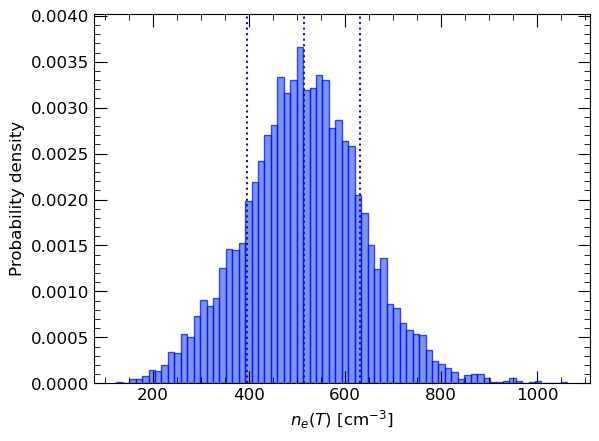

In [24]:
### PLOT
%matplotlib inline
histplot = plt.hist(elec_density,bins=70,color='royalblue',edgecolor='blue',density=True,alpha=0.7)
plt.vlines([low_lim,high_lim],0,max(histplot[0])*1.1,linestyles=':',colors='midnightblue')
plt.vlines(median,0,max(histplot[0])*1.1,linestyles=':',colors='midnightblue')
plt.ylim(0,max(histplot[0])*1.1)
plt.ylabel('Probability density', fontsize=12)
plt.xlabel(r'$n_e(T)$ [cm$^{-3}$]', fontsize=12)
#plt.xlim(0,400)
#plt.title(str(name))
plt.minorticks_on()
plt.tick_params(axis='both', which='major', labelsize=12)
plt.tick_params(axis='both', which='major', length=9)
plt.tick_params(axis='both', which='minor', length=4.5)
plt.tick_params(axis='both', which='both',direction='in',right=True,top=True)
#plt.savefig(str(name)+'_peculiar_velocity.png')
plt.show()

### Assuming that the bow shock is from Bremsstrahlung emission instead of Synchrotron

We use a cylindrical unit volume in the bow shock (beam time thickness) and the average flux density (0.15 mJy/beam). The resulting particle density should be compared with that from the IRAS modelling. 

In [25]:
Fluxuv = np.random.normal(Flobe,Flobe_err,n_iter)
elec_densityuv = Parallel(n_jobs=n_cores,verbose=5)(delayed(ne)(dist[i],Fluxuv[i],Ring_thic[i],T_axis[i],nu,Z) for i in range(n_iter))
median = np.percentile(elec_densityuv,50)
low_lim = np.percentile(elec_densityuv,16)
high_lim = np.percentile(elec_densityuv,84)
print('Median =',median,'; Lower limit = ',low_lim,'; Upper limit = ',high_lim)

[Parallel(n_jobs=16)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  48 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 512 tasks      | elapsed:    0.2s


Median = 84.28401250423096 ; Lower limit =  66.0595827604326 ; Upper limit =  96.83159532142511


[Parallel(n_jobs=16)]: Done 4224 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 4969 out of 5000 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=16)]: Done 5000 out of 5000 | elapsed:    0.4s finished


Unshocked version:

In [26]:
print('Median =',median/4,'; Lower limit = ',low_lim/4,'; Upper limit = ',high_lim/4)


Median = 21.07100312605774 ; Lower limit =  16.51489569010815 ; Upper limit =  24.207898830356278


### 2) Shock velocity

In [27]:
v_range =    ((16*T_axis*kb)/(3*mh))**(1/2)/1e5
v_range_cm = ((16*T_axis*kb)/(3*mh))**(1/2)
print('{:.3e}'.format(min(v_range_cm)),'{:.3e}'.format(max(v_range_cm)))

2.098e+06 3.633e+07


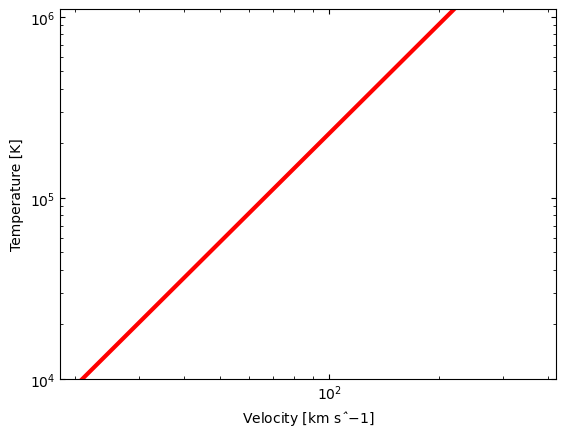

In [28]:
### PLOT
fig = plt.figure()
ax = fig.add_subplot(111)

ax.yaxis.set_ticks_position('both')
ax.xaxis.set_ticks_position('both')
ax.get_yaxis().set_tick_params(direction='in', which='both')
ax.get_xaxis().set_tick_params(direction='in', which='both')

ax.plot(v_range, T_axis, 'r-', lw=3)

ax.set_ylim(1e4, 1.1e6)
#ax.set_ylim(3., 5e2)
ax.set_xscale('log')
ax.set_yscale('log')

ax.set_xlabel(r'Velocity [km s$ˆ{-1}$]')
ax.set_ylabel(r'Temperature [K]')

plt.show()

### 3) Jet age

In [29]:
# Generating distribution arrays for measurements
len_min = np.random.normal(disamin,disamin_err, n_iter) #distance between bowshock and target in arcmin
i_angle = np.random.normal(incl,incl_err,n_iter)        #inclination angle
#Obtaining distribution of age for different input parameters
t_age = Parallel(n_jobs=n_cores,verbose=5)(delayed(age)(len_min[i],dist[i],i_angle[i],v_range_cm[i]) for i in range(n_iter))

median = np.percentile(t_age,50)
low_lim = np.percentile(t_age,16)
high_lim = np.percentile(t_age,84)
tsmax_sim = np.percentile(t_age,95)
tsabs_sim = np.percentile(t_age,99.9)
print('Median =',median,'Lower limit = ',low_lim,'Upper limit = ',high_lim, 'Absolute upper limit:',tsabs_sim)

[Parallel(n_jobs=16)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  48 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 512 tasks      | elapsed:    0.1s


Median = 0.12234532613196332 Lower limit =  0.09352310247000262 Upper limit =  0.2162871677167302 Absolute upper limit: 1.2562973519834066


[Parallel(n_jobs=16)]: Done 4224 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 4969 out of 5000 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=16)]: Done 5000 out of 5000 | elapsed:    0.3s finished


Median = 0.12234532613196332 Lower limit =  0.09352310247000262 Upper limit =  0.2162871677167302


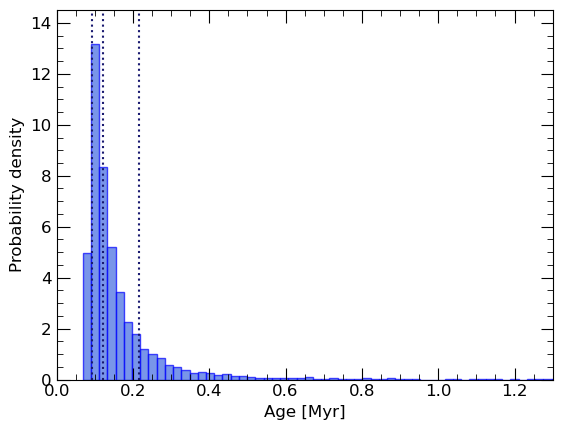

In [30]:
### PLOT
print('Median =',median,'Lower limit = ',low_lim,'Upper limit = ',high_lim)
histplot = plt.hist(t_age,bins=70,color='royalblue',edgecolor='blue',density=True,alpha=0.7)
plt.vlines([low_lim,high_lim],0,max(histplot[0])*1.1,linestyles=':',colors='midnightblue')
plt.vlines(median,0,max(histplot[0])*1.1,linestyles=':',colors='midnightblue')
plt.ylim(0,max(histplot[0])*1.1)
plt.ylabel('Probability density', fontsize=12)
plt.xlabel('Age [Myr]', fontsize=12)
plt.xlim(0,1.3)
#plt.title(str(name))
plt.minorticks_on()
plt.tick_params(axis='both', which='major', labelsize=12)
plt.tick_params(axis='both', which='major', length=9)
plt.tick_params(axis='both', which='minor', length=4.5)
plt.tick_params(axis='both', which='both',direction='in',right=True,top=True)
#plt.savefig(str(name)+'_peculiar_velocity.png')
plt.show()

### 4) Jet power

In [31]:
# Generating distribution arrays for measurements
open_angle = np.random.uniform(1, o_a, n_iter) #opening angle distribution
#Obtaining distribution for different input parameters

print('open_angle = ',np.mean(open_angle))
print('d = ', d)
print('elec_density = ',np.mean(elec_density))
print('len_min = ',np.mean(len_min))
print('v_range_cm = ',np.mean(v_range_cm))


power_j = Parallel(n_jobs=n_cores,verbose=5)(delayed(power)(open_angle[i],d,elec_density[i],len_min[i],v_range_cm[i]) for i in range(n_iter))

median = np.percentile(power_j,50)
low_lim = np.percentile(power_j,16)
high_lim = np.percentile(power_j,84)
print('Median =',median,'Lower limit = ',low_lim,'Upper limit = ',high_lim)

[Parallel(n_jobs=16)]: Using backend LokyBackend with 16 concurrent workers.


open_angle =  5.472794821496475
d =  9.399999999999999
elec_density =  514.9368568207834
len_min =  16.99751246889851
v_range_cm =  24296199.482018065


[Parallel(n_jobs=16)]: Done  48 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 512 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 4224 tasks      | elapsed:    0.2s


Median = 3.0947062021045954e+38 Lower limit =  3.2899495605351473e+37 Upper limit =  1.5089349795800372e+39


[Parallel(n_jobs=16)]: Done 4969 out of 5000 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=16)]: Done 5000 out of 5000 | elapsed:    0.3s finished


In [32]:
power_juv = Parallel(n_jobs=n_cores,verbose=5)(delayed(power)(open_angle[i],d,elec_densityuv[i],len_min[i],v_range_cm[i]) for i in range(n_iter))

median = np.percentile(power_juv,50)
low_lim = np.percentile(power_juv,16)
high_lim = np.percentile(power_juv,84)
print('Median =',median,'Lower limit = ',low_lim,'Upper limit = ',high_lim)

[Parallel(n_jobs=16)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  48 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 512 tasks      | elapsed:    0.1s


Median = 5.063445361377839e+37 Lower limit =  5.32659769413681e+36 Upper limit =  2.4047599717926502e+38


[Parallel(n_jobs=16)]: Done 4224 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 4969 out of 5000 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=16)]: Done 5000 out of 5000 | elapsed:    0.3s finished


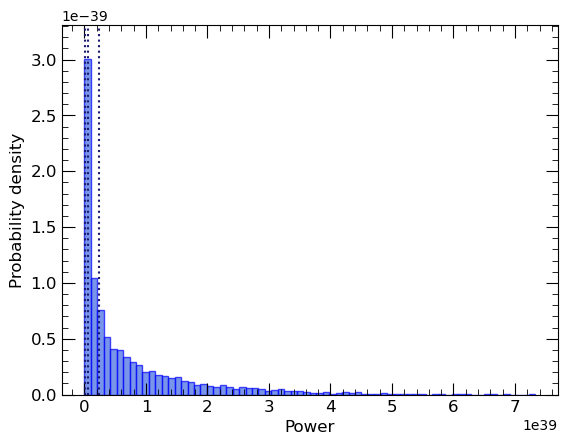

In [33]:
### PLOT
histplot = plt.hist(power_j,bins=70,color='royalblue',edgecolor='blue',density=True,alpha=0.7)
plt.vlines([low_lim,high_lim],0,max(histplot[0])*1.1,linestyles=':',colors='midnightblue')
plt.vlines(median,0,max(histplot[0])*1.1,linestyles=':',colors='midnightblue')
plt.ylim(0,max(histplot[0])*1.1)
plt.ylabel('Probability density', fontsize=12)
plt.xlabel('Power', fontsize=12)
#plt.xlim(0,400)
#plt.title(str(name))
plt.minorticks_on()
plt.tick_params(axis='both', which='major', labelsize=12)
plt.tick_params(axis='both', which='major', length=9)
plt.tick_params(axis='both', which='minor', length=4.5)
plt.tick_params(axis='both', which='both',direction='in',right=True,top=True)
#plt.savefig(str(name)+'_peculiar_velocity.png')
plt.show()

##### 4A) Total injected power

In [34]:
def totalpower(Pjet,jet_age):
    Ptot = Pjet*jet_age 
    return Ptot

powtot = totalpower(Qjetmin,tsmin)
print(powtot)

8.621934887083594e+47


In [35]:
totpower_j = Parallel(n_jobs=n_cores,verbose=5)(delayed(totalpower)(power_j[i], t_age[i]) for i in range(n_iter))
median = np.percentile(totpower_j,50)
low_lim = np.percentile(totpower_j,16)
high_lim = np.percentile(totpower_j,84)
print('Median =',median*(365.0*24.0*60.0*60.0),'Lower limit = ',low_lim*(365.0*24.0*60.0*60.0),'Upper limit = ',high_lim*(365.0*24.0*60.0*60.0))

[Parallel(n_jobs=16)]: Using backend LokyBackend with 16 concurrent workers.


Median = 1.2794104160241416e+45 Lower limit =  1.821756771572416e+44 Upper limit =  5.0187607791916455e+45


[Parallel(n_jobs=16)]: Done  48 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 512 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 4224 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 4969 out of 5000 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=16)]: Done 5000 out of 5000 | elapsed:    0.1s finished


##### 4B) Jet pressure


In [36]:
press_j = Parallel(n_jobs=n_cores,verbose=5)(delayed(press)(open_angle[i],d,elec_density[i],len_min[i],v_range_cm[i]) for i in range(n_iter))

median = np.percentile(press_j,50)
low_lim = np.percentile(press_j,16)
high_lim = np.percentile(press_j,84)
print('Median =',median,'Lower limit = ',low_lim,'Upper limit = ',high_lim)

[Parallel(n_jobs=16)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  48 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 512 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 4224 tasks      | elapsed:    0.2s


Median = 2.032839275842751e-10 Lower limit =  2.847500564152863e-11 Upper limit =  7.825964176969326e-10


[Parallel(n_jobs=16)]: Done 4969 out of 5000 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=16)]: Done 5000 out of 5000 | elapsed:    0.3s finished


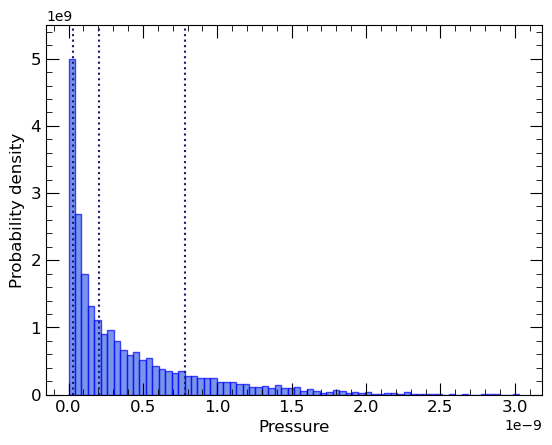

In [37]:
### PLOT
#print('Median =',median,'; Lower limit = ',low_lim,'; Upper limit = ',high_lim)
histplot = plt.hist(press_j,bins=70,color='royalblue',edgecolor='blue',density=True,alpha=0.7)
plt.vlines([low_lim,high_lim],0,max(histplot[0])*1.1,linestyles=':',colors='midnightblue')
plt.vlines(median,0,max(histplot[0])*1.1,linestyles=':',colors='midnightblue')
plt.ylim(0,max(histplot[0])*1.1)
plt.ylabel('Probability density', fontsize=12)
plt.xlabel('Pressure', fontsize=12)
#plt.xlim(0,400)
#plt.title(str(name))
plt.minorticks_on()
plt.tick_params(axis='both', which='major', labelsize=12)
plt.tick_params(axis='both', which='major', length=9)
plt.tick_params(axis='both', which='minor', length=4.5)
plt.tick_params(axis='both', which='both',direction='in',right=True,top=True)
#plt.savefig(str(name)+'_peculiar_velocity.png')
plt.show()

### 5) Pseudo constant


In [38]:
open_a = np.random.uniform(1,o_a, n_iter) #opening angle
g_c = np.random.uniform(4/3,5/3, n_iter) 
g_j = np.random.uniform(4/3,5/3, n_iter) 

In [39]:
ce_1 = Parallel(n_jobs=n_cores,verbose=5)(delayed(C_cons)(g_c[i],g_j[i],(5.0/3),open_a[i]) for i in range(n_iter))

median = np.percentile(ce_1,50)
low_lim = np.percentile(ce_1,16)
high_lim = np.percentile(ce_1,84)
print('Median =',median,'; Lower limit = ',low_lim,'; Upper limit = ',high_lim)

[Parallel(n_jobs=16)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  48 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 512 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 4224 tasks      | elapsed:    0.2s


Median = 4.396947195498367 ; Lower limit =  3.673687969405048 ; Upper limit =  6.106664684788413


[Parallel(n_jobs=16)]: Done 4969 out of 5000 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=16)]: Done 5000 out of 5000 | elapsed:    0.3s finished


Median = 4.396947195498367 ; Lower limit =  3.673687969405048 ; Upper limit =  6.106664684788413


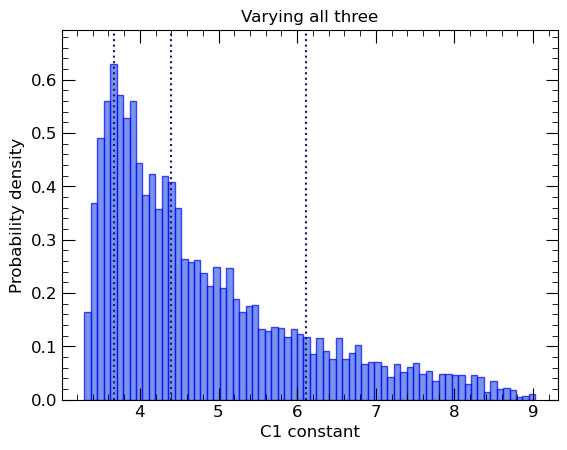

In [40]:
### PLOT
print('Median =',median,'; Lower limit = ',low_lim,'; Upper limit = ',high_lim)
histplot = plt.hist(ce_1,bins=70,color='royalblue',edgecolor='blue',density=True,alpha=0.7)
plt.vlines([low_lim,high_lim],0,max(histplot[0])*1.1,linestyles=':',colors='midnightblue')
plt.vlines(median,0,max(histplot[0])*1.1,linestyles=':',colors='midnightblue')
plt.ylim(0,max(histplot[0])*1.1)
plt.ylabel('Probability density', fontsize=12)
plt.xlabel('C1 constant', fontsize=12)
#plt.xlim(0,400)
plt.title('Varying all three')
plt.minorticks_on()
plt.tick_params(axis='both', which='major', labelsize=12)
plt.tick_params(axis='both', which='major', length=9)
plt.tick_params(axis='both', which='minor', length=4.5)
plt.tick_params(axis='both', which='both',direction='in',right=True,top=True)
#plt.savefig(str(name)+'_peculiar_velocity.png')
plt.show()

In [41]:
ce_1 = Parallel(n_jobs=n_cores,verbose=5)(delayed(C_cons)(g_c[i],(5.0/3),(5.0/3),open_a[i]) for i in range(n_iter))

median = np.percentile(ce_1,50)
low_lim = np.percentile(ce_1,16)
high_lim = np.percentile(ce_1,84)
print('Median =',median,'; Lower limit = ',low_lim,'; Upper limit = ',high_lim)

[Parallel(n_jobs=16)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  48 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 512 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 4224 tasks      | elapsed:    0.2s


Median = 4.228298243302703 ; Lower limit =  3.5246880761027373 ; Upper limit =  5.879026958634341


[Parallel(n_jobs=16)]: Done 4969 out of 5000 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=16)]: Done 5000 out of 5000 | elapsed:    0.2s finished


Median = 4.228298243302703 ; Lower limit =  3.5246880761027373 ; Upper limit =  5.879026958634341


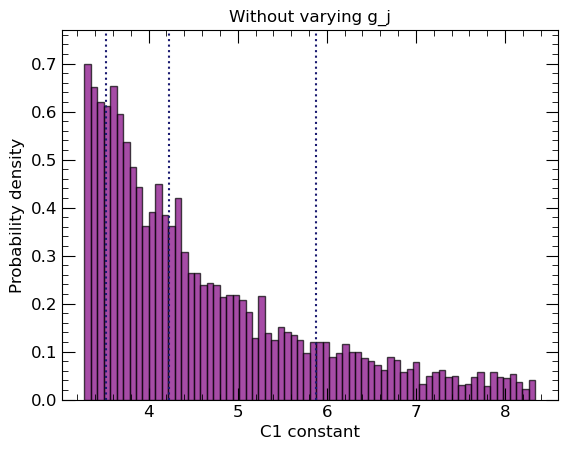

In [42]:
#PLOT
print('Median =',median,'; Lower limit = ',low_lim,'; Upper limit = ',high_lim)
histplot = plt.hist(ce_1,bins=70,color='Purple',edgecolor='black',density=True,alpha=0.7)
plt.vlines([low_lim,high_lim],0,max(histplot[0])*1.1,linestyles=':',colors='midnightblue')
plt.vlines(median,0,max(histplot[0])*1.1,linestyles=':',colors='midnightblue')
plt.ylim(0,max(histplot[0])*1.1)
plt.ylabel('Probability density', fontsize=12)
plt.xlabel('C1 constant', fontsize=12)
#plt.xlim(0,400)
plt.title('Without varying g_j')
plt.minorticks_on()
plt.tick_params(axis='both', which='major', labelsize=12)
plt.tick_params(axis='both', which='major', length=9)
plt.tick_params(axis='both', which='minor', length=4.5)
plt.tick_params(axis='both', which='both',direction='in',right=True,top=True)
#plt.savefig(str(name)+'_peculiar_velocity.png')
plt.show()

In [43]:
ce_1 = Parallel(n_jobs=n_cores,verbose=5)(delayed(C_cons)((5.0/3),g_j[i],(5.0/3),open_a[i]) for i in range(n_iter))

median = np.percentile(ce_1,50)
low_lim = np.percentile(ce_1,16)
high_lim = np.percentile(ce_1,84)
print('Median =',median,'; Lower limit = ',low_lim,'; Upper limit = ',high_lim)

[Parallel(n_jobs=16)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  48 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 512 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 4224 tasks      | elapsed:    0.2s


Median = 4.39711184147335 ; Lower limit =  3.67731407934992 ; Upper limit =  6.106505571194216


[Parallel(n_jobs=16)]: Done 4969 out of 5000 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=16)]: Done 5000 out of 5000 | elapsed:    0.2s finished


Median = 4.39711184147335 ; Lower limit =  3.67731407934992 ; Upper limit =  6.106505571194216


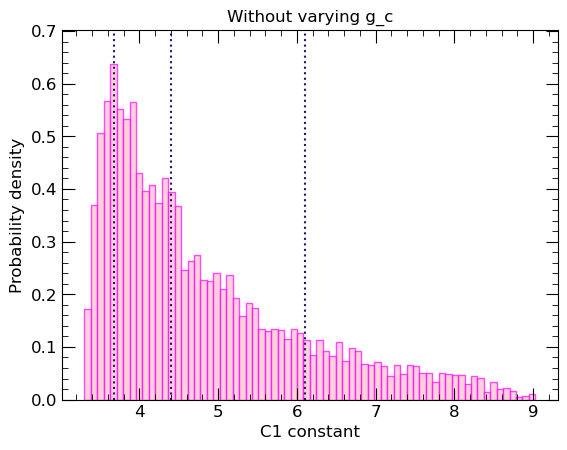

In [44]:
#PLOT
print('Median =',median,'; Lower limit = ',low_lim,'; Upper limit = ',high_lim)
histplot = plt.hist(ce_1,bins=70,color='pink',edgecolor='magenta',density=True,alpha=0.7)
plt.vlines([low_lim,high_lim],0,max(histplot[0])*1.1,linestyles=':',colors='midnightblue')
plt.vlines(median,0,max(histplot[0])*1.1,linestyles=':',colors='midnightblue')
plt.ylim(0,max(histplot[0])*1.1)
plt.ylabel('Probability density', fontsize=12)
plt.xlabel('C1 constant', fontsize=12)
#plt.xlim(0,400)
plt.title('Without varying g_c')
plt.minorticks_on()
plt.tick_params(axis='both', which='major', labelsize=12)
plt.tick_params(axis='both', which='major', length=9)
plt.tick_params(axis='both', which='minor', length=4.5)
plt.tick_params(axis='both', which='both',direction='in',right=True,top=True)
#plt.savefig(str(name)+'_peculiar_velocity.png')
plt.show()

# Other simple jet estimate

### 1) Enthalpy

Often in the AGN community the jet power is estimated by calculating the enthalpy and dividing by an appropriate timescale. Enthalpy is defined as  $dH = dU + pdV$ (from thermodynamics). It includes the energy stored in a volume and the work done in excavating it, so it measures the total energy/heat input by the jet. 

Enthalpy of an ideal gas with adiabatic index $\gamma$ is given by 
$$
H = U + P V = \frac{PV}{(\gamma -1)} + PV 
$$
which for non-relavistic ideal gas comes out as $H= 4 PV$. The jet power is thus

$$
Q = \frac{4PV}{\tau}
$$

where: 
* $P$ is the the pressure from the minimum energy condition applied to synchrotron emission from the lobes
* $V$ is the the volume from assuming a spherical bubble with radius equal to the approximate radius of the bubble near GRS 1915
* $\tau$ is the the jet age from the jet length divided by the bow shock velocity 

From above we have that the minimum energy pressure in the lobe is $P \sim 1.3\times 10^{-12}~{\rm erg~s^{-1}}$. 

We assume that the lobe is a cylinder with length equal to the source-to-bow shock distance, and width equal to the lobe width. 

This implies a volume of the order $10^{60}$ cm$^3$. 
The (upper limit to the) jet age $\tau$ is around $1.1$ Myr from the self-similar estimate (but this is the same order  as just lengh/shock velocity $L/\dot{L}$. 

Putting this all together we get:
$$
Q  \sim 1.2\times 10^{35}~{\rm erg~s}^{-1} 
$$
which is not too far our estimate from the self-similar model. Note that this is a lower limit because we used an upper limit for $\tau$. Additioanlly, it's easy for this to be higher, as a the presence of a non radiating pressure component (and/or a non volume filling synchrotron plasma) would increase the value. 

If we take the pressure from the self-similar model (but on this case the estimate is not indipendent any more), then the pressure inside the lobe is $P \sim 3.6\times 10^{-11}~{\rm erg~s^{-1}}$, and the enthaly becomes: 
$$
Q  \sim 3.6\times 10^{36}~{\rm erg~s}^{-1} 
$$

In the simulation below we see that if we calculate properly the limits, this estimate is perfectly consistent with the jet energy estimated in the self similar model. 

In [45]:
def enthalpy(P,Vlobe,tau):
    QH = 4*P*Vlobe/tau
    return QH


P = pminlobe
Llobe = discm
tau = tsmax_sim*(365.*24.*60*60)*1.0E+6
Blobe = lobesizecm
VlobeCyl = np.pi*(Llobe)*(Blobe/2)**2     # Assuming that the volume here is cylinder
                                       # with length equal to the source-to-bow shock
                                       # distance, and the width is the lobe width.  

Vlobe = 4/3*np.pi*(Llobe/2)*(Blobe/2)**2 # Assuming that the volume here is an ellipsoidal shape
                                        # with length equal to the source-to-bow shock
                                        # distance, and the width is the lobe width.  

QH  = enthalpy(P,Vlobe,tau)
QHcyl  = enthalpy(P,VlobeCyl,tau)

print('Lobe Volume ellipsoidal [cm**3] ~ ', '{:.3e}'.format(Vlobe))
print('Lobe Volume cylinder [cm**3] ~ ', '{:.3e}'.format(VlobeCyl))

print('Average jet power (ellipsoidal) [erg/s] (H) ~ ', '{:.3e}'.format(QH))
print('Average jet power (cylinder) [erg/s] (H) ~ ', '{:.3e}'.format(QHcyl))

Lobe Volume ellipsoidal [cm**3] ~  5.993e+59
Lobe Volume cylinder [cm**3] ~  8.990e+59
Average jet power (ellipsoidal) [erg/s] (H) ~  2.558e+35
Average jet power (cylinder) [erg/s] (H) ~  3.837e+35


In [46]:
tau = np.multiply(t_age,(365.0*24.0*60.0*60.0)*1.0E+6)

QHdis = Parallel(n_jobs=n_cores,verbose=5)(delayed(enthalpy)(press_j[i],Vlobe,tau[i]) for i in range(n_iter))

median = np.percentile(QHdis,50)
low_lim = np.percentile(QHdis,16)
high_lim = np.percentile(QHdis,84)
print('Median =',median,'; Lower limit = ',low_lim,'; Upper limit = ',high_lim)

[Parallel(n_jobs=16)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  48 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 512 tasks      | elapsed:    0.0s


Median = 1.1668316048161157e+38 ; Lower limit =  1.2361201501827133e+37 ; Upper limit =  5.720767715513208e+38


[Parallel(n_jobs=16)]: Done 4224 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 4969 out of 5000 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=16)]: Done 5000 out of 5000 | elapsed:    0.1s finished


### 2) The "Hotspot Method"

Under the assumption of equipartition, Godfrey and Shabala (https://arxiv.org/abs/1301.3499) give the hotspot power as 

$$
Q_{\rm GS} = A c \frac{B_{\rm eq}^2}{8\pi} g
$$

where $g$ is a complicated expression which we could evaluate, but for the simplicity's sake we will take their estimate of $g \approx 2$ from the AGN case. $A$ is the area of the hotspot surface, which we will assume is a circular surface with radius $R \approx 7.6 \times 10^{18}~{\rm cm}$ based on the are of the elongated feature north-west from the IRAS region. The minimum energy magnetic field as estimated above is as $22~{\rm \mu G}$. 
We thus have: 

$$
Q_{\rm GS} = A c \frac{B_{\rm eq}^2}{8\pi} = 2 \pi R^2 c \frac{B_{\rm eq}^2}{8\pi} \sim 1.7 \times 10^{36}~{\rm erg~s}^{-1}
$$

We note that this is once more a lover limit, and, again, departures from equipartition will increase this estimate, which is already remarkably consistent with the "average" power estimate above. 

In [47]:
def hotspotpower(rcyl,lencyl,Bmin):
    A = 2*rcyl*lencyl
    QHS =  A*c*Bmin**2/(8*np.pi)
    return QHS

QHS = hotspotpower(rcylcm,lencylcm,Bmin)

In [48]:
print('Average jet power (GS) ~', '{:.3e}'.format(QHS))

Average jet power (GS) ~ 1.727e+36


(No simulation here 'cause there's no distribution to build).

## Jet power constraint from proper motion time 

In [49]:
disasec =disamin*60 #lobe target seperation in arcsec (projected)
dispc = disasec*d10*10*1e3*4.8*1e-6  #lobe target separation in pc (projected)
discmP = dispc*pc #lobe target sepeartion in cm (projected)
discm = discmP/np.sin(incl*np.pi/180) #lobe target de-projected seperation to account for the inclination angle

L = discm
tauup = 0.17*(365.*24.*60*60)*1.0E+6           #upper limit to jet age
Tlow = ((3*L/(5*tauup))**2)*((3*mh)/(16*kb))  #lower limit to temperature
neup = nesph(d10*10,Firas,Riras,Tlow,nu,Z)

print('>> Lower limit on Temperature as set by the proper motion (0.17 My to slice through IRAS) ~','{:.3e}'.format(Tlow))


>> Lower limit on Temperature as set by the proper motion (0.17 My to slice through IRAS) ~ 7.656e+05


### All the important quantities in one place

In [50]:
print('---- IRAS ---- ')

print('IRAS diameter [arcsec and pc] =', '{:.3e}'.format(Riras),' and ','{:.3e}'.format(Rirascm/pc))
print('IRAS volume [cm] =', '{:.3e}'.format(Volsph))
print('IRAS flux density [mJy] =','{:.3e}'.format(Firas*1000))
print('Electron temperature [K] =','{:.3e}'.format(min(T_axis)),'-','{:.3e}'.format(max(T_axis)))
print('Shock-compressed Electron density [particles/cm3] =','{:.3e}'.format(np.percentile(elec_density,16)),'-','{:.3e}'.format(np.percentile(elec_density,84)))
print('Pre-Shock Electron density [particles/cm3] =','{:.3e}'.format(np.percentile(elec_density,16)/4),'-','{:.3e}'.format(np.percentile(elec_density,84)/4))

print('Shock velocity [Km/s] =','{:.3e}'.format(min(v_range)),'-','{:.3e}'.format(max(v_range)))
print('Pressure inside IRAS (ideal gas conditions) [erg/cm3] (Pideal) = ', '{:.3e}'.format(pidealmin),' and ', '{:.3e}'.format(pidealmax))

print('Pressure in ISM (ideal gas conditions) [erg/cm3] =', '{:.3e}'.format(pidealunsh))


print('\n','---- Hot spot (Cylinder)----')

print('Cylinder flux density [mJy] =','{:.3e}'.format(Fcyl*1000))
print('Cylinder Integrated Luminosity [erg/s] (Lcy) =','{:.3e}'.format(Lcy))
print('Cylinder radius [arcsec and pc] =','{:.3e}'.format(rcyl),' and ', '{:.3e}'.format(rcylcm/pc))
print('Cylinder length [arcsec and pc] =','{:.3e}'.format(lencyl),' and ','{:.3e}'.format(lencylcm/pc))
print('Cylinder Volume [cm3] =',' and ','{:.3e}'.format(VolCyl))
print('Cylinder pressure [erg/cm3]  ~','{:.3e}'.format(pmincyl))
print('Cylinder magnetic field density [G] = ','{:.3e}'.format(Bmin))


print('\n','---- Lobe ----')

print('Lobe flux density [mJy] =','{:.3e}'.format(Flobe*1000))
print('Source-ring separation (projected) [arcsec and pc] ~',' and ','{:.3e}'.format(disamin),'{:.3e}'.format(dispc))
print('Lobe diameter [arcmin and pc]  =', '{:.3e}'.format(theam),' and ','{:.3e}'.format(lobesizecm/pc))
print('Ring thickness [arcsec and pc] =','{:.3e}'.format(DR),' and','{:.3e}'.format(DRcm/pc))
print('Lobe Volume [cm**3] ~ ', '{:.3e}'.format(Vlobe))
print('Equipartition lobe pressure [erg/cm3] =','{:.3e}'.format(pminlobe))
print('Jet pressure [erg/cm3] ~ ','{:.3e}'.format(pminjet))
print('Equipartition lobe magnetic field [G] =','{:.3e}'.format(Bminlobe))

print('\n','---- Energetics -----')

print('Jet age [Myr] =','{:.3e}'.format(np.percentile(t_age,16)),' and ','{:.3e}'.format(np.percentile(t_age,84)))
print('Jet power [erg/s]  ~ ','{:.3e}'.format(np.percentile(power_j,16)),' and ','{:.3e}'.format(np.percentile(power_j,84)))
print('Jet power Enthalpy [erg/s]  ~ ','{:.3e}'.format(np.percentile(QHdis,16)),' and ','{:.3e}'.format(np.percentile(QHdis,84)))
print('Jet power Hot Spot [erg/s]  ~ ', '{:.3e}'.format(QHS))
print('Jet pressure (inside IRAS) [erg/cm3] = ', '{:.3e}'.format(np.percentile(press_j,16)),'-','{:.3e}'.format(np.percentile(press_j,84)))
print('Pseudo constant C  ~ ','{:.3e}'.format(min(ce_1)),' and ','{:.3e}'.format(max(ce_1)))



---- IRAS ---- 
IRAS diameter [arcsec and pc] = 3.600e+01  and  1.624e+00
IRAS volume [cm] = 6.595e+55
IRAS flux density [mJy] = 5.700e+01
Electron temperature [K] = 1.000e+04 - 3.000e+06
Shock-compressed Electron density [particles/cm3] = 3.951e+02 - 6.300e+02
Pre-Shock Electron density [particles/cm3] = 9.877e+01 - 1.575e+02
Shock velocity [Km/s] = 2.098e+01 - 3.633e+02
Pressure inside IRAS (ideal gas conditions) [erg/cm3] (Pideal) =  2.575e-10  and  7.725e-08
Pressure in ISM (ideal gas conditions) [erg/cm3] = 1.288e-12

 ---- Hot spot (Cylinder)----
Cylinder flux density [mJy] = 5.200e+00
Cylinder Integrated Luminosity [erg/s] (Lcy) = 1.998e+29
Cylinder radius [arcsec and pc] = 3.900e+00  and  1.760e-01
Cylinder length [arcsec and pc] = 1.740e+01  and  9.065e-01
Cylinder Volume [cm3] =  and  2.592e+54
Cylinder pressure [erg/cm3]  ~ 1.488e-11
Cylinder magnetic field density [G] =  2.182e-05

 ---- Lobe ----
Lobe flux density [mJy] = 1.500e-01
Source-ring separation (projected) [arcse